# Étape 1 : Préparation des données
Le LSTM nécessite des données sous forme de séquences temporelles. Voici comment nous allons préparer ces données :

## 1.1. Importation des bibliothèques nécessaires et chargement des données

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv('sensor_data_with_anomalies.csv')

# Afficher un échantillon des données
print(df.head())

   temperature        ph  turbidite         tds  oxygene_dissoute  \
0    27.483571  6.660753   1.104486  301.942803          7.528142   
1    24.308678  6.847250   1.084997  394.501435          9.012702   
2    28.238443  6.701309   0.719044  441.297159          7.801813   
3    32.615149  7.055209   1.173875  514.966891          8.090569   
4    23.829233  7.598589   0.552975  602.416233          8.717391   

   conductivite  
0   1529.461844  
1   1480.767531  
2   1785.537227  
3   1959.849342  
4   1706.054083  


## 1.2. Normalisation des données
Nous devons normaliser les données pour que les valeurs se situent dans une plage entre 0 et 1, ce qui aide l'algorithme LSTM à mieux apprendre.

In [34]:
# Normalisation des données entre 0 et 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Vérification de la forme des données normalisées
print(scaled_data.shape)

(10000, 6)


### scaled_data.shape retourne (10000, 6), ce qui signifie que :
### Il y a **10 000 lignes** de données dans votre DataFrame.
### Il y a **6 colonnes** , correspondant aux capteurs : température, pH, turbidité, TDS, oxygène dissous, conductivité.

## 1.3. Transformation des données en séquences
Pour LSTM, nous devons diviser nos données en fenêtres de séquences temporelles. Par exemple, si nous utilisons une fenêtre de 50, le modèle prendra en compte les 50 précédentes observations pour prédire la suivante.

In [36]:
# Fonction pour créer des séquences avec une fenêtre
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]  # Label est la valeur suivante
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Définir la longueur de la séquence 
sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification des formes après transformation
print(X_train.shape, y_train.shape)


(7992, 10, 6) (7992, 6)


# X_train.shape : (7992, 10, 6)
### **7992** : Il y a 7 992 séquences dans l'ensemble d'entraînement.
### **10** : Chaque séquence contient 10 observations temporelles.
### **6** : Chaque observation contient 6 valeurs, correspondant aux 6 capteurs (température, pH, turbidité, etc.).

# Étape 2 : Création du modèle LSTM

## 2.1. Définir l'architecture du modèle
Nous allons construire un modèle LSTM avec quelques couches LSTM, de dropout pour éviter le surapprentissage, et une couche de sortie dense.

In [38]:
# Création du modèle LSTM
model = Sequential()

# Première couche LSTM
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Deuxième couche LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Couche de sortie dense (une sortie par valeur prédite)
model.add(Dense(units=X_train.shape[2]))

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Résumé du modèle
model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,482 (162.04 KB)

 Trainable params: 41,482 (162.04 KB)

 Non-trainable params: 0 (0.00 B)

## Modèle Séquentiel (Sequential) :
Le modèle est créé en utilisant l'API Sequential de Keras, qui permet d'empiler les couches les unes après les autres. C'est un choix simple et approprié pour ce type de modèle où les couches sont linéaires.
## 2. Première couche LSTM 
**LSTM** : La première couche est une couche LSTM (Long Short-Term Memory) avec 64 unités (ou neurones). Le LSTM est particulièrement efficace pour capturer les relations temporelles dans les séquences de données.

return_sequences=True : Cela indique que cette couche LSTM renvoie les séquences complètes à chaque étape, plutôt que juste la dernière sortie. Comme vous avez une deuxième couche LSTM, vous avez besoin que la sortie de cette couche soit une séquence pour la prochaine couche.

input_shape=(X_train.shape[1], X_train.shape[2]) :

**X_train.shape[1]** correspond à la longueur de la séquence (ici 10).
**X_train.shape[2]** correspond au nombre de caractéristiques (ici 6 capteurs).
Cela signifie que la couche LSTM attend des séquences de 10 pas de temps avec 6 caractéristiques à chaque pas.


**Dropout** est une technique de régularisation qui aide à éviter le surapprentissage (overfitting) en désactivant aléatoirement 20 % des neurones pendant l'entraînement (indiqué par 0.2). Cela force le modèle à être plus robuste et moins dépendant d'un sous-ensemble particulier de neurones.
## La deuxième couche LSTM a 50 unités (ou neurones).
return_sequences=False : Cela signifie que cette couche LSTM ne renverra que la dernière sortie, pas la séquence entière, car c'est la dernière couche récurrente de votre réseau. Elle est conçue pour condenser l'information des séquences passées en une seule représentation, que vous utiliserez pour la prédiction.

## Couche de sortie Dense 
Dense est une couche entièrement connectée (couche classique de réseau de neurones).
units=X_train.shape[2] signifie que la couche de sortie aura 6 unités, ce qui correspond au nombre de capteurs (température, pH, etc.). Cela signifie que pour chaque séquence en entrée, le modèle prédira 6 valeurs (une pour chaque capteur).

## Optimizer : 
L'optimiseur utilisé est Adam, qui est un algorithme d'optimisation efficace et populaire pour l'entraînement de réseaux de neurones.
Loss (fonction de perte) : La fonction de perte choisie est mean_squared_error (erreur quadratique moyenne), ce qui est standard pour des tâches de régression où l'objectif est de minimiser la différence entre les valeurs prédites et les valeurs réelles

## **Interprétation des résultats** :
LSTM (64 unités) : Cette couche a une sortie de forme (None, 10, 64), ce qui signifie que pour chaque séquence de 10 pas de temps, il y a 64 unités activées. Le nombre de paramètres dans cette couche est 18 176.

Paramètres LSTM : Ce nombre de paramètres est calculé comme suit :
Paramètres = (64 * (64 + 6 + 1)) * 4 = 18,176 (où 64 est le nombre d'unités, 6 est le nombre de caractéristiques d'entrée, et 1 est pour le biais).
LSTM (50 unités) : La deuxième couche LSTM a une sortie de forme (None, 50), ce qui signifie que pour chaque séquence d'entrée, il ne reste que 50 unités activées. Le nombre de paramètres ici est 23 000.

Paramètres LSTM : Calculé comme : (50 * (50 + 64 + 1)) * 4 = 23 000.
Dense : La couche Dense a 6 unités, correspondant à la prédiction de 6 valeurs (une pour chaque capteur). Le nombre de paramètres est 306, calculé comme : (50 * 6) + 6 = 306 (où 50 est le nombre d'unités en entrée et 6 est le nombre de neurones de sortie, plus le biais).



# Étape 3 : Entraînement du modèle
Nous allons entraîner le modèle en définissant un certain nombre d'époques et la taille du batch. Nous utilisons les données d'entraînement pour ajuster le modèle.

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0274 - val_loss: 0.0032
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 

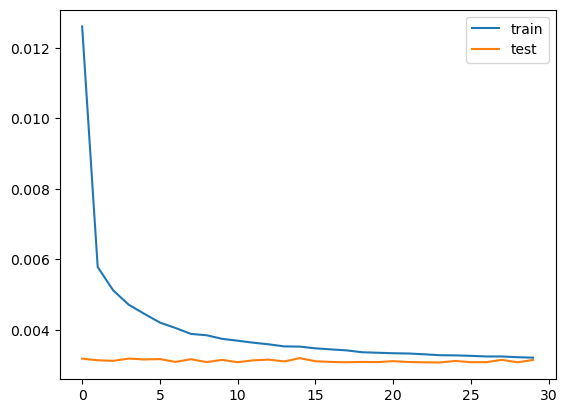

In [40]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Visualisation de la courbe de perte
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Étape 4 : Évaluation des performances du modèle
Après l'entraînement, nous devons évaluer les performances du modèle sur les données de test et voir comment il se comporte.

In [41]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Inverser la normalisation pour interpréter les résultats
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Calculer la différence (erreur) entre les vraies valeurs et les valeurs prédites
errors = np.mean(np.abs(y_test_rescaled - y_pred_rescaled), axis=1)

# Afficher les erreurs pour détecter les anomalies
print(errors[:10])

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
[ 97.50389753  40.35493838  16.45815839 110.55901855   6.21630054
  26.76398033  40.92188288  41.92531173  81.99732476   6.46053152]


# Étape 5 : Détection des anomalies
Nous allons définir un seuil pour identifier les anomalies en fonction de l'erreur de prédiction.

In [46]:
# Définir un seuil d'erreur (par exemple, tout ce qui est au-dessus de 95e percentile est une anomalie)
threshold = np.percentile(errors, 95)

# Marquer comme anomalies les prédictions qui dépassent le seuil
anomalies = errors > threshold

# Afficher le pourcentage d'anomalies
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)} sur {len(errors)}")

Nombre d'anomalies détectées: 100 sur 1998


In [50]:
# Sauvegarder le modèle
model.save('lstm_anomaly_model.h5')

# Sauvegarder le scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']